# Image denoising by a supervised learning 

In [286]:
import os
from pyexpat import model
import torch
from torchvision import transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import statistics

In [287]:
from MyDataset import MyDataset
from MyEval import MyEval
from MyModel import MyModel
from MyResult import MyResult
from MyTrain import MyTrain

## construct dataset for training (split=`mytrain` should be used)

In [288]:
dataset = MyDataset(path='data', split='mytrain')

## construct dataloader

In [289]:
batch_size = 128 # you can change this value
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

## plot the dataset

In [290]:
iter_data       = iter(dataloader)
(data, label)   = next(iter_data)
print(data.shape, label.shape)
print(data.dtype, label.dtype)

torch.Size([128, 1, 16, 16]) torch.Size([128])
torch.float32 torch.int64


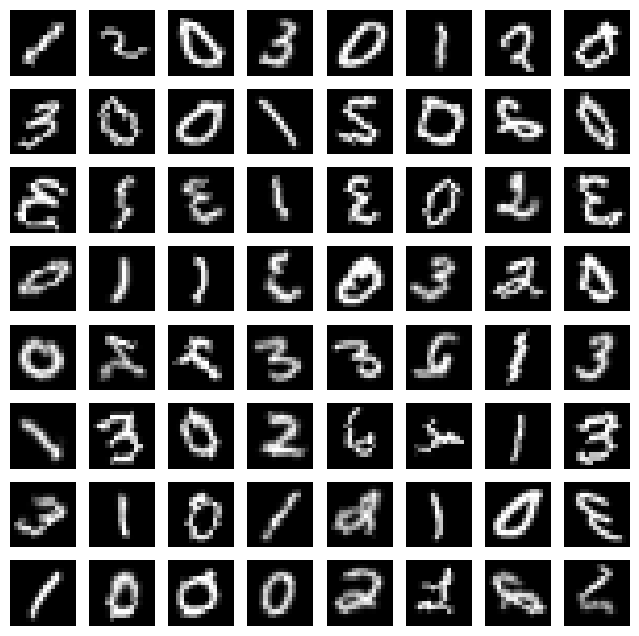

In [291]:
nRow = 8
nCol = 8
plt.figure(figsize=(nRow, nCol))
for i in range(nRow):
    for j in range(nCol):
        idx = nCol * i + j
        plt.subplot(nRow, nCol, idx+1)
        plt.axis('off')
        plt.imshow(data[idx].squeeze(0), cmap='gray')
plt.show()

## plot the noisy dataset

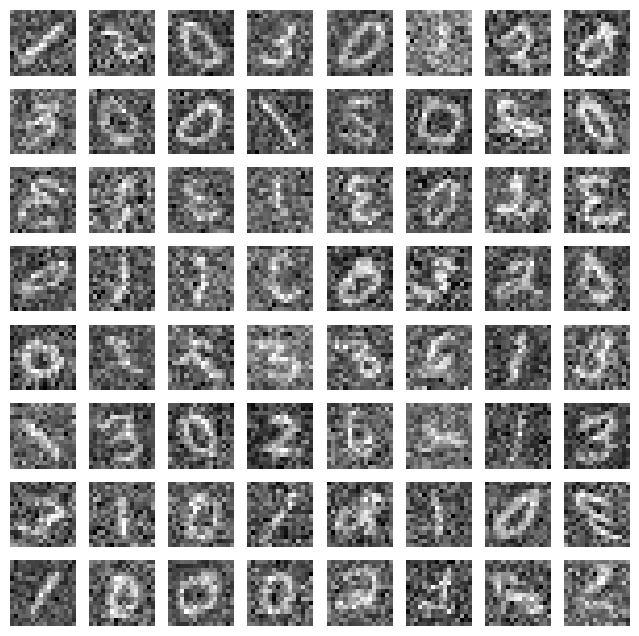

In [292]:
std_noise = 0.5
nRow = 8
nCol = 8
plt.figure(figsize=(nRow, nCol))
for i in range(nRow):
    for j in range(nCol):
        idx = nCol * i + j
        plt.subplot(nRow, nCol, idx+1)
        plt.axis('off')
        im = data[idx] + torch.randn_like(data[idx]) * std_noise 
        plt.imshow(im.squeeze(0), cmap='gray') 
plt.show()

## construct model

In [293]:
model       = MyModel()
size_model  = model.size()
noise       = torch.randn_like(data) * std_noise 
input       = data + noise
pred        = model(input)
print(f'data: {data.shape}')
print(f'input: {input.shape}')
print(f'output: {pred.shape}')
print('model size =', size_model)
print(f'min(data)={data.min()}, max(data)={data.max()}')
print(f'min(input)={input.min()}, max(input)={input.max()}')
print(f'min(pred)={pred.min()}, max(pred)={pred.max()}')

data: torch.Size([128, 1, 16, 16])
input: torch.Size([128, 1, 16, 16])
output: torch.Size([128, 1, 16, 16])
model size = 185473
min(data)=-1.0, max(data)=1.0
min(input)=-3.12893009185791, max(input)=2.4804060459136963
min(pred)=-0.4693349599838257, max(pred)=0.7106735110282898


## train (you should not use the ground truth)

In [294]:
trainer = MyTrain(model,dataloader,epochs=100,reg = 0.45)

trainer.train(input)

Epoch [1/100], Loss: 150.669535
Epoch [2/100], Loss: 128.628395
Epoch [3/100], Loss: 111.322319
Epoch [4/100], Loss: 97.488777
Epoch [5/100], Loss: 86.393560
Epoch [6/100], Loss: 77.703667
Epoch [7/100], Loss: 71.125114
Epoch [8/100], Loss: 66.290540
Epoch [9/100], Loss: 62.773752
Epoch [10/100], Loss: 60.087987
Epoch [11/100], Loss: 57.871513
Epoch [12/100], Loss: 55.992048
Epoch [13/100], Loss: 54.471395
Epoch [14/100], Loss: 53.341408
Epoch [15/100], Loss: 52.517067
Epoch [16/100], Loss: 51.859123
Epoch [17/100], Loss: 51.277095
Epoch [18/100], Loss: 50.755694
Epoch [19/100], Loss: 50.305962
Epoch [20/100], Loss: 49.918074
Epoch [21/100], Loss: 49.572482
Epoch [22/100], Loss: 49.255646
Epoch [23/100], Loss: 48.965579
Epoch [24/100], Loss: 48.702573
Epoch [25/100], Loss: 48.465692
Epoch [26/100], Loss: 48.251274
Epoch [27/100], Loss: 48.056878
Epoch [28/100], Loss: 47.879517
Epoch [29/100], Loss: 47.716087
Epoch [30/100], Loss: 47.564832
Epoch [31/100], Loss: 47.425045
Epoch [32/100]

## save the trained model

In [295]:
model.eval()
model.save()    # save the trained model in 'model.pth'

## load the trained model

In [296]:
model = MyModel()   # model should not require any argument!
model.load()
model.eval()

MyModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

## evaluation

In [297]:
eval    = MyEval()
result  = MyResult()

## evaluation of the trained model on the training dataset (split=`train`)

In [298]:
batch_size  = 10 
dataset     = MyDataset(path='data', split='train') 
dataloader  = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False)

eval.psnr_reset()
for step, (data, _) in enumerate(tqdm(dataloader)):
    noise   = torch.randn_like(data) * std_noise
    input   = data + noise
    output  = model(input)
    eval.psnr_update(output, data)

psnr_value = eval.psnr_compute()
result.add_result('train', psnr_value)
print(f'PSNR (train): {psnr_value}')

  0%|          | 0/40 [00:00<?, ?it/s]

PSNR (train): 29.84429931640625


## evaluation of the trained model on the validation dataset (split=`val`)

In [299]:
batch_size  = 10 
dataset     = MyDataset(path='data', split='val') 
dataloader  = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False)

eval.psnr_reset()
for step, (data, _) in enumerate(tqdm(dataloader)):
    noise   = torch.randn_like(data) * std_noise 
    input   = data + noise
    output  = model(input)
    eval.psnr_update(output, data)

psnr_value = eval.psnr_compute()
result.add_result('val', psnr_value)
print(f'PSNR (val): {psnr_value}')

  0%|          | 0/10 [00:00<?, ?it/s]

PSNR (val): 29.941524505615234


## save the result

In [300]:
result.save()